In [1]:
import os
os.getcwd()

'C:\\Users\\User\\Documents\\Studia\\NLP\\project2\\src'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

In [3]:
name = 'own_cnn_bow'
data = '../data/own_mod.parquet'

## 1: Load data

In [4]:
df = pd.read_parquet(data)
df

,text,score
0,description say maybe cream cheese cream chees...,1
1,terrible followed recipe exactly tasted fine a...,1
2,im always amazed people rate recipe state chan...,1
3,didnt like creamy rich didnt feel good sour cr...,1
4,even using green chilies much hot u like,1
...,...,...
1407,good omitted green chilies dont like lot heat ...,5
1408,cut calorie fat way using nonfat sour cream su...,5
1409,wonderful recipe used oz light cream cheese in...,5
1410,good thing would leave salt use lower sodium b...,5


### 2.3 Feature Extraction

#### 2.3.1 Bag of words

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features= 32*32)

X = vectorizer.fit_transform(df.text)
X

<1412x1024 sparse matrix of type '<class 'numpy.int64'>'
	with 22836 stored elements in Compressed Sparse Row format>

## 2.4 Split Dataset

In [6]:
Y = np.array([[y>1, y>2, y>3, y>4] for y in df.score])

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

del X
del Y

In [8]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)

X_train (1129, 1024)
y_train (1129, 4)


In [9]:
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_test (283, 1024)
y_test (283, 4)


## 3 Build model

In [10]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers

In [11]:
model_input = layers.Input(X_train.shape[1], sparse=True)
l = layers.Lambda(tf.sparse.to_dense)(model_input)
l = layers.Reshape((32, 32, 1))(l)
l = layers.Conv2D(32, (3, 3), activation='relu')(l)
l = layers.MaxPooling2D((2, 2))(l)
l = layers.Conv2D(64, (3, 3), activation='relu')(l)
l = layers.MaxPooling2D((2, 2))(l)
l = layers.Conv2D(64, (3, 3), activation='relu')(l)
l = layers.Flatten()(l)
l = layers.Dense(64, activation='relu')(l)
model_output = layers.Dense(4, activation='sigmoid')(l)

model = keras.Model(model_input, model_output)

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1024)]            0         
                                                                 
 lambda (Lambda)             (None, None)              0         
                                                                 
 reshape (Reshape)           (None, 32, 32, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                             

In [13]:
def score_accuracy(y_true, y_pred):
    return tf.math.reduce_sum(y_true, axis=1) == tf.math.round(tf.math.reduce_sum(y_pred, axis=1))

def score_distance(y_true, y_pred):
    return tf.math.abs(tf.math.reduce_sum(y_true, axis=1) - tf.math.round(tf.math.reduce_sum(y_pred, axis=1)))

In [14]:
model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'binary_crossentropy', metrics=[score_accuracy, score_distance])

In [15]:
def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.SparseTensor(indices, coo.data, coo.shape)

X_train = convert_sparse_matrix_to_sparse_tensor(X_train)
X_test = convert_sparse_matrix_to_sparse_tensor(X_test)

In [16]:
X_train = tf.sparse.reorder(X_train)
X_test = tf.sparse.reorder(X_test)

In [17]:
hist = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=50,
    validation_data = (X_test, y_test)
)

Epoch 1/50
36/36 [==============================] - 9s 20ms/step - loss: 0.6001 - score_accuracy: 0.2108 - score_distance: 1.2019 - val_loss: 0.5738 - val_score_accuracy: 0.2191 - val_score_distance: 1.1837
Epoch 2/50
36/36 [==============================] - 0s 8ms/step - loss: 0.5527 - score_accuracy: 0.2135 - score_distance: 1.1709 - val_loss: 0.5371 - val_score_accuracy: 0.2509 - val_score_distance: 1.0919
Epoch 3/50
36/36 [==============================] - 0s 8ms/step - loss: 0.4963 - score_accuracy: 0.2569 - score_distance: 1.0115 - val_loss: 0.5251 - val_score_accuracy: 0.3004 - val_score_distance: 1.0283
Epoch 4/50
36/36 [==============================] - 0s 8ms/step - loss: 0.4708 - score_accuracy: 0.2755 - score_distance: 0.9557 - val_loss: 0.4994 - val_score_accuracy: 0.2756 - val_score_distance: 1.0106
Epoch 5/50
36/36 [==============================] - 0s 9ms/step - loss: 0.4260 - score_accuracy: 0.3313 - score_distance: 0.8592 - val_loss: 0.5348 - val_score_accuracy: 0.247

In [23]:
model.save(f'../models/{name}')

INFO:tensorflow:Assets written to: ../models/own_cnn_bow\assets


INFO:tensorflow:Assets written to: ../models/own_cnn_bow\assets


In [24]:
hist_df = pd.DataFrame(hist.history)
hist_df

,loss,score_accuracy,score_distance,val_loss,val_score_accuracy,val_score_distance
0,0.600137,0.210806,1.201949,0.573791,0.219081,1.183746
1,0.552702,0.213463,1.170948,0.537076,0.250883,1.091873
2,0.496291,0.256864,1.011515,0.525097,0.300353,1.028269
3,0.470756,0.275465,0.955713,0.499423,0.275618,1.010601
4,0.425990,0.331267,0.859167,0.534796,0.247350,1.038869
5,0.392849,0.357839,0.795394,0.497995,0.346290,0.922261
6,0.367099,0.377325,0.751107,0.479204,0.328622,0.918728
7,0.333939,0.426926,0.682905,0.483622,0.346290,0.886926
8,0.304303,0.489814,0.596103,0.484836,0.339223,0.893993
9,0.280020,0.519043,0.558016,0.490467,0.371025,0.851590


In [20]:
hist_df.to_csv(f'../logs/{name}.csv')

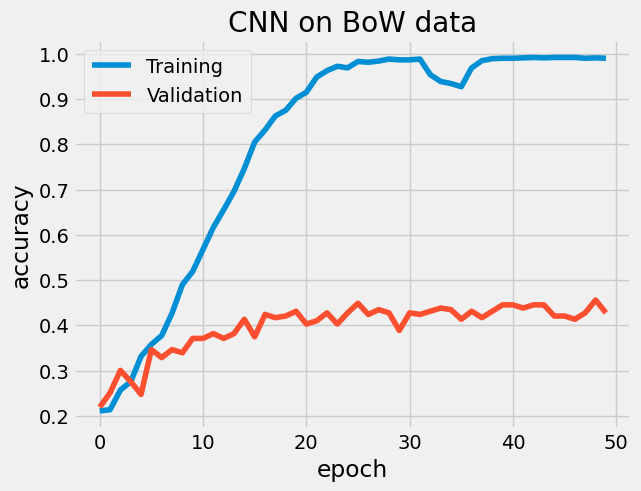

In [22]:
plt.title('CNN on BoW data')

plt.plot(hist_df.score_accuracy, label='Training')
plt.plot(hist_df.val_score_accuracy, label='Validation')

plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.savefig(f'../figs/{name}.png')
plt.show()